In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
import torch
from nltk.metrics.distance import edit_distance
from difflib import SequenceMatcher
from spellchecker import SpellChecker
from scipy.optimize import curve_fit
import nltk
from time import time
nltk.download('words')

[nltk_data] Downloading package words to C:\Users\bills-fish-
[nltk_data]     shack\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [2]:
# adapted from Ruan on stackoverflow
class GPT2:
    def __init__(self):
        self.model     = GPT2LMHeadModel.from_pretrained("gpt2")
        self.tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
    
    def get_predictions(self, sentence):  # Encode the sentence using the tokenizer and return the model predictions.
        inputs = self.tokenizer.encode(sentence, return_tensors="pt")
        with torch.no_grad():
            outputs = self.model(inputs)
            predictions = outputs[0]
        return predictions
    
    def get_next_word_probabilities(self, sentence, n=50257):
        predictions = self.get_predictions(sentence)
        candidates = predictions[0, -1, :]                          # Get the next token candidates.
        topk_i = torch.topk(candidates, n).indices.tolist()         # Get the top k next token candidates.
        all_probs = torch.nn.functional.softmax(candidates, dim=-1) # Get the token probabilities for all candidates.
        topk_probs = all_probs[topk_i].tolist()                     # Filter the token probabilities for the top k candidates.
        topk_tokens = [self.tokenizer.decode([idx]).strip()         # Decode the top k candidates back to words.
                       for idx in topk_i]
        return list(zip(topk_tokens, topk_probs))
        
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()
wl    = set(nltk.corpus.words.words())
in_wl = np.vectorize(lambda x: x in wl)
lin_map = np.vectorize(lambda x: 2*x - 1)  # allow to be applied along vectors
log_map = lambda e: np.vectorize(lambda x: np.power(np.log(x/0.5)/np.log(2), e))  # specify exponent to return vectorized mapping
arrLower   = np.vectorize(lambda x: x.lower())
spelling   = SpellChecker()
model = GPT2()

In [3]:
t0=time()
strings = ["when you come over can you being", "can you really climb all the way up that birdling",
           "I rally", "This method isn't really as grape"]
data    = []
metric  = ["log-map prob", "geomean", "harmean"][0]
for string in strings:
    last_space = string.rfind(' ')
    prompt = string[:last_space]
    target = string[last_space+1:]
    probsp = [(word, prob, similar(target, word)) for word, prob in model.get_next_word_probabilities(prompt, 5000) if word in wl]
    close_probs = [prob for prob in probsp if prob[2] > 0.5 and prob[1] >= min(0.001, probsp[500][1])]
    close_adj = pd.DataFrame([(word, sim, lin_map(sim), log_map(np.e)(sim), prob, 
                               prob*lin_map(sim), prob*log_map(np.e)(sim), np.sqrt(prob*log_map(np.e)(sim)),
                               (2*prob*log_map(np.e)(sim))/(prob+log_map(np.e)(sim))) 
                              for word, prob, sim in close_probs],
                             columns=["word", "similarity", "lin-map sim", "log-map sim", 
                                      "probability", "lin-map prob", "log-map prob", "geomean", "harmean"])
    close_adj["log-map sim"] = close_adj["log-map sim"].apply(pd.to_numeric)
    close_adj["lin-map sim"] = close_adj["lin-map sim"].apply(pd.to_numeric)
    props = close_adj[["word", metric]].sort_values(metric, ascending=False).values
    data.append([(prompt, target), probsp, props])
t1=time()
t1-t0

0.6226437091827393

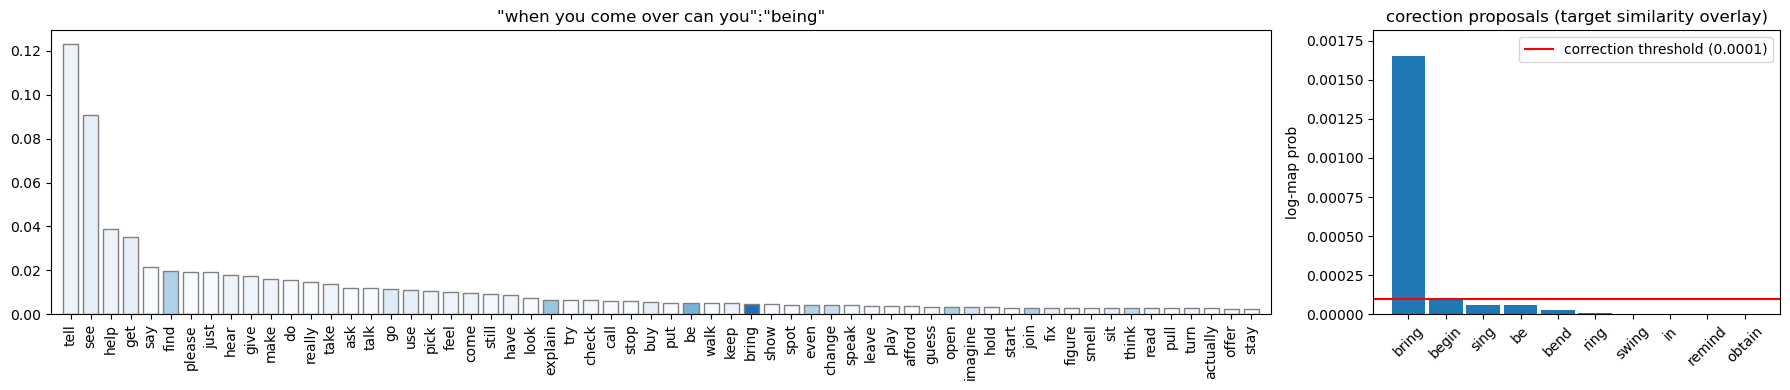

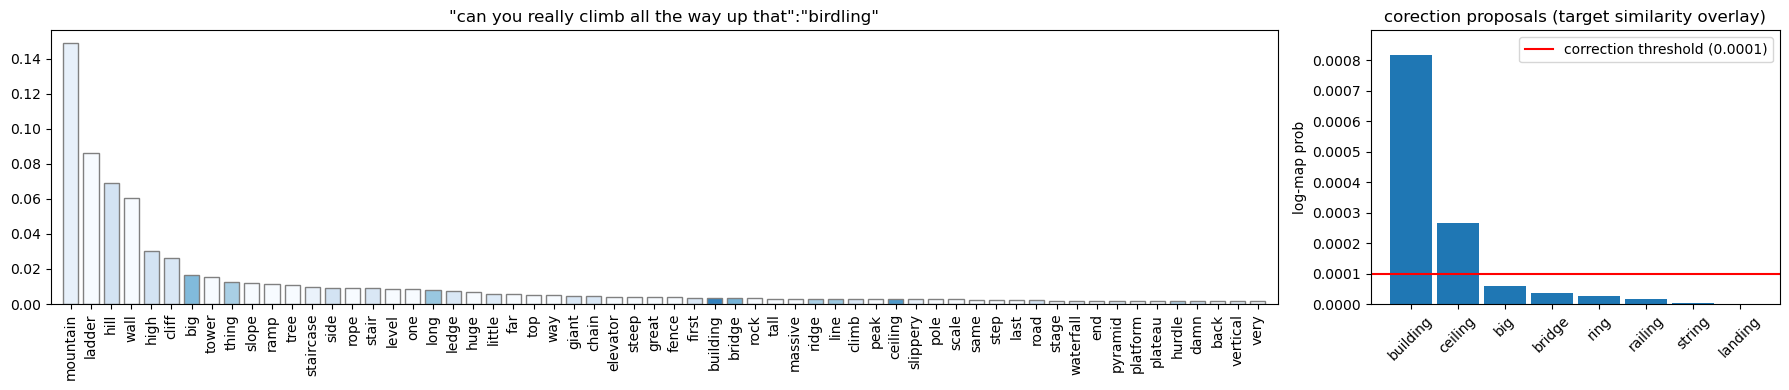

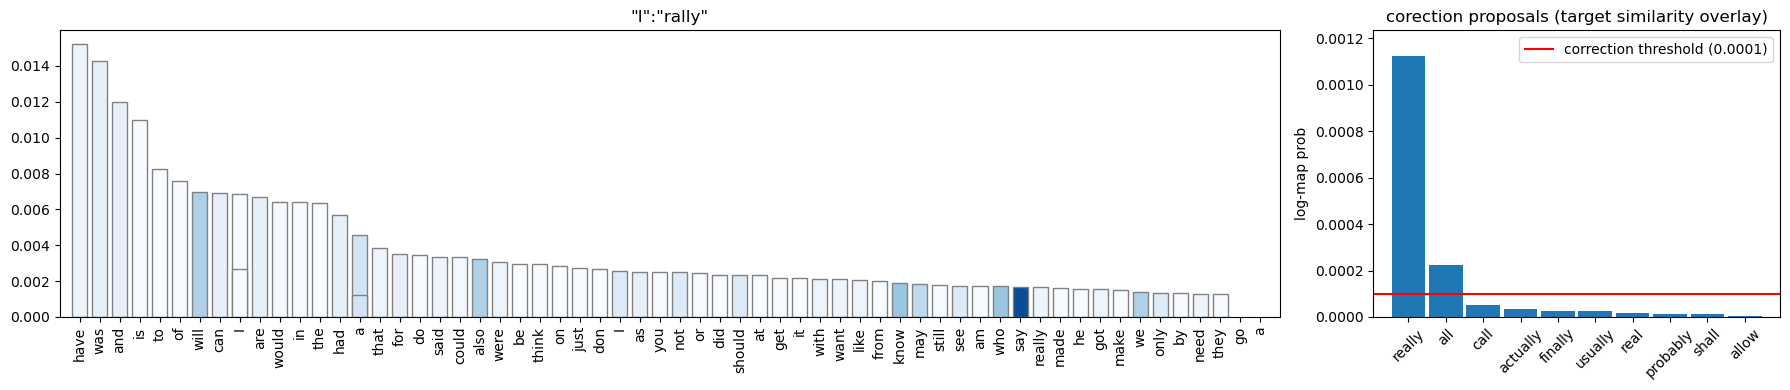

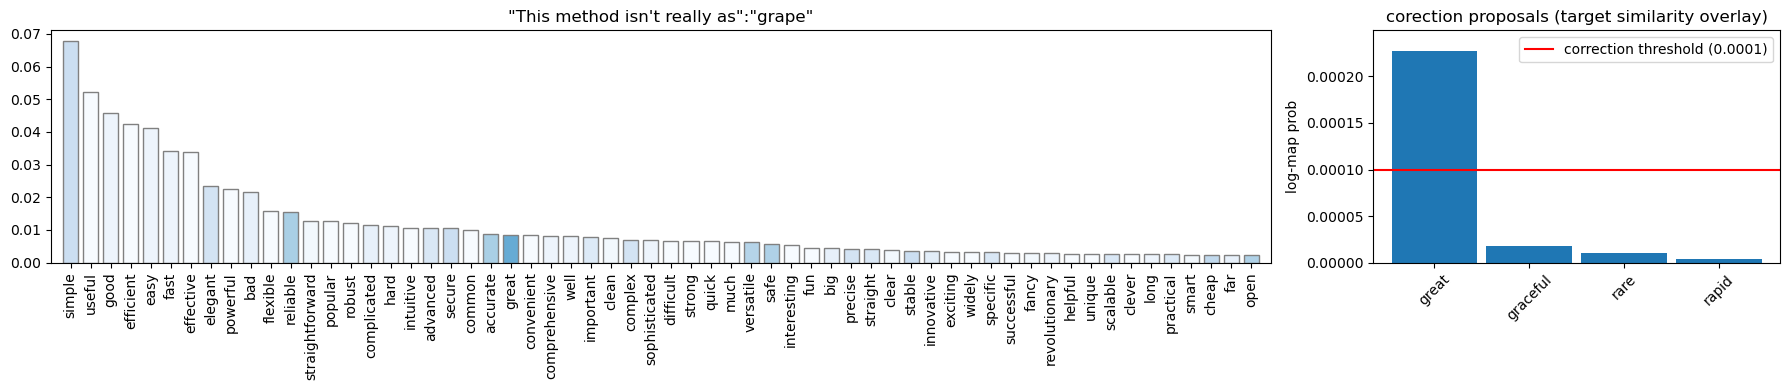

In [4]:
for (prompt, target), probsp, props in data:
    fig, ax = plt.subplots(1, 2, figsize=(18,4), width_ratios=(3,1))
    topN = 60
    probs_plot = np.array(probsp[:topN])
    cmap = mpl.colormaps['Blues']
    norm = mpl.colors.Normalize(vmin=0.18, vmax=1.0)
    ax[0].bar(probs_plot[:,0], probs_plot[:,1].astype(float), width=0.75, edgecolor='gray',
            color=cmap(norm(probs_plot[:,2].astype(float))))
    ax[0].set_xlim(-1,topN)
    ax[0].set_xticks(range(len(probs_plot[:,0])), probs_plot[:,0], rotation=90, fontsize=10)
    ax[0].set_title(f'"{prompt if len(prompt) < 130 else f"...{prompt[-130:]}"}":"{target}"')
    probN = {"log-map prob": 0.0001, "geomean": 0.015, "harmean": 0}[metric]
    propsp = props[:10]
    if len(propsp) == 0:
        propsp = np.array([['', 0]])
    ax[1].bar(propsp[:,0], propsp[:,1], width=.9)
    ax[1].set_xticks(range(len(propsp[:,0])), propsp[:,0], rotation=45)
    ax[1].set_ylim([0, max(float(propsp[0,1])*1.1, probN*1.18)])
    ax[1].axhline(y=probN, color='r', label=f'correction threshold ({probN})')
    ax[1].set_title('corection proposals (target similarity overlay)')
    ax[1].set_ylabel(metric)
    ax[1].legend(loc="upper right")
    plt.tight_layout()
    plt.show()

In [5]:
thresholdN = 200
topN       = 10
probN      = 0.0001
def correction(string):
    last_space = string.rfind(' ')
    if last_space == -1:
        if spelling.correction(string) == string:
            return None
        return spelling.correction(string)
    prompt = string[:last_space]
    target = string[last_space+1:]
    sc_target = spelling.correction(target)
    probsp = [(word, prob, similar(sc_target, word)) for word, prob in model.get_next_word_probabilities(prompt, 10000)]
    close_adj = [(word, prob*log_map(np.e)(sim)) for word, prob, sim in probsp if sim > 0.5 and prob >= min(0.001, probsp[thresholdN][1])]
    close_adj = np.array(sorted(close_adj, key=lambda x: x[1], reverse=True)[:topN])
    if len(close_adj) == 0 or sc_target.lower() in arrLower(close_adj[:,0]) or close_adj[0,1].astype(float) < probN:
        if target != sc_target:
            return sc_target
        return None
    return close_adj[0,0]

In [6]:
print(correction("Give me about half an hour and I'll bee"))

be
